In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
#env:lpr


In [2]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/plots/JMAR/4Aug2014"
_ = os.system(f"mkdir -p {plot_dir}")

# Check ROC

In [4]:
df0 = uproot.lazy('/home/pku/zhaoyz/Higgs/boostedHWW/scale_factors/coffea_output/qcd.root')
df0['event_type'] = 0
df1 = uproot.lazy('/home/pku/zhaoyz/Higgs/boostedHWW/scale_factors/coffea_output/ttbar.root')
df1['event_type'] = 1
df = ak.concatenate([df0, df1])

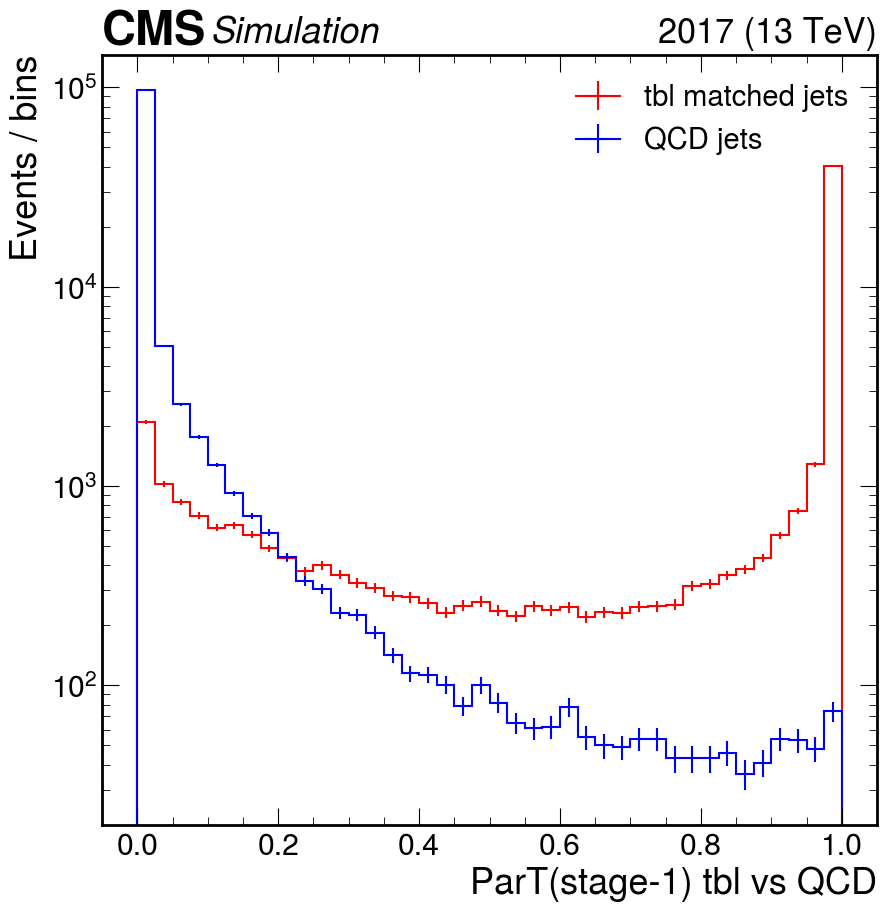

In [6]:
f, ax = plt.subplots(figsize=(10,10))
hep.cms.label(data=False, year="2017", ax=ax, fontname='sans-serif')
plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','darkviolet'])
nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

hist.fill(df.fj1_ParTV1_discr_blvsQCD[df.event_type == 1])
content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr,label = "tbl matched jets")

hist2 = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

hist2.fill(df.fj1_ParTV1_discr_blvsQCD[df.event_type == 0])
content, yerr = hist2.view().value, np.sqrt(hist2.view().variance)
hep.histplot(content, bins=hist2.axes[0].edges, yerr=yerr,label = "QCD jets")

ax.legend(loc="upper right",frameon=False,fontsize=21)
ax.set_xlabel('ParT(stage-1) tbl vs QCD', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);
ax.set_yscale("log")

plt.savefig(f"{plot_dir}/Tagger_distribution_log.pdf")
plt.show()


In [12]:
np.logspace(np.log10(0.1), np.log10(200), 100)

array([1.00000000e-01, 1.07980103e-01, 1.16597026e-01, 1.25901589e-01,
       1.35948666e-01, 1.46797509e-01, 1.58512102e-01, 1.71161531e-01,
       1.84820397e-01, 1.99569255e-01, 2.15495087e-01, 2.32691817e-01,
       2.51260863e-01, 2.71311739e-01, 2.92962695e-01, 3.16341420e-01,
       3.41585791e-01, 3.68844689e-01, 3.98278875e-01, 4.30061940e-01,
       4.64381325e-01, 5.01439433e-01, 5.41454816e-01, 5.84663468e-01,
       6.31320215e-01, 6.81700219e-01, 7.36100598e-01, 7.94842184e-01,
       8.58271409e-01, 9.26762351e-01, 1.00071894e+00, 1.08057734e+00,
       1.16680853e+00, 1.25992105e+00, 1.36046405e+00, 1.46903048e+00,
       1.58626062e+00, 1.71284586e+00, 1.84953272e+00, 1.99712733e+00,
       2.15650015e+00, 2.32859109e+00, 2.51441505e+00, 2.71506796e+00,
       2.93173318e+00, 3.16568851e+00, 3.41831371e+00, 3.69109867e+00,
       3.98565214e+00, 4.30371129e+00, 4.64715188e+00, 5.01799939e+00,
       5.41844090e+00, 5.85083807e+00, 6.31774097e+00, 6.82190321e+00,
      

In [7]:
# # custom selection
effs = {}
# for mindr in [0.2, 0.3, 0.4, 0.5]:
#     for ptrel in [30]:
for mindr in [0.4]:
    for ptrel in np.logspace(np.log10(0.1), np.log10(200), 100):
        sel = (df.lep_mindr_jet > mindr) | (df.lep_ptrel_jet > ptrel)
        _df = df[sel]
        effs[f'({mindr}, {ptrel})'] = (len(_df[_df.event_type == 1]) / len(df[df.event_type == 1]), len(_df[_df.event_type == 0]) / len(df[df.event_type == 0]))

effs1 = {}
for mindr in np.arange(0.1, 0.8, 0.01):
    for ptrel in [40]:
        sel = (df.lep_mindr_jet > mindr) | (df.lep_ptrel_jet > ptrel)
        _df = df[sel]
        effs1[f'({mindr}, {ptrel})'] = (len(_df[_df.event_type == 1]) / len(df[df.event_type == 1]), len(_df[_df.event_type == 0]) / len(df[df.event_type == 0]))

In [14]:
effs

{'(0.4, 0.1)': (0.8769796380090498, 0.919017874472853),
 '(0.4, 0.10798010298258112)': (0.8677967793452223, 0.9126568207082738),
 '(0.4, 0.11659702640128823)': (0.8577155975512377, 0.9058458172321917),
 '(0.4, 0.12590158918273833)': (0.8474181527814746, 0.8980290438127504),
 '(0.4, 0.135948665656227)': (0.8363388341762045, 0.8902828507402114),
 '(0.4, 0.14679750917903883)': (0.8238621240351344, 0.8818396767420111),
 '(0.4, 0.1585121015873901)': (0.8108697098749001, 0.8725583611243449),
 '(0.4, 0.17116153053391742)': (0.7976277615118446, 0.8621742275863286),
 '(0.4, 0.184820396937086)': (0.7832712270428533, 0.8517106911580471),
 '(0.4, 0.19956925494548067)': (0.7681660899653979, 0.8408148501049882),
 '(0.4, 0.21549508701169987)': (0.7517134681927069, 0.8286309177209606),
 '(0.4, 0.23269181687763632)': (0.7350944902848017, 0.8159529229086161),
 '(0.4, 0.2512608634965108)': (0.7172777482033538, 0.8025691246272475),
 '(0.4, 0.27131173915845486)': (0.6983297844024487, 0.7880207506219893),
 

/tmp/ipykernel_3041792/4268216113.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df.event_type).astype(np.int)


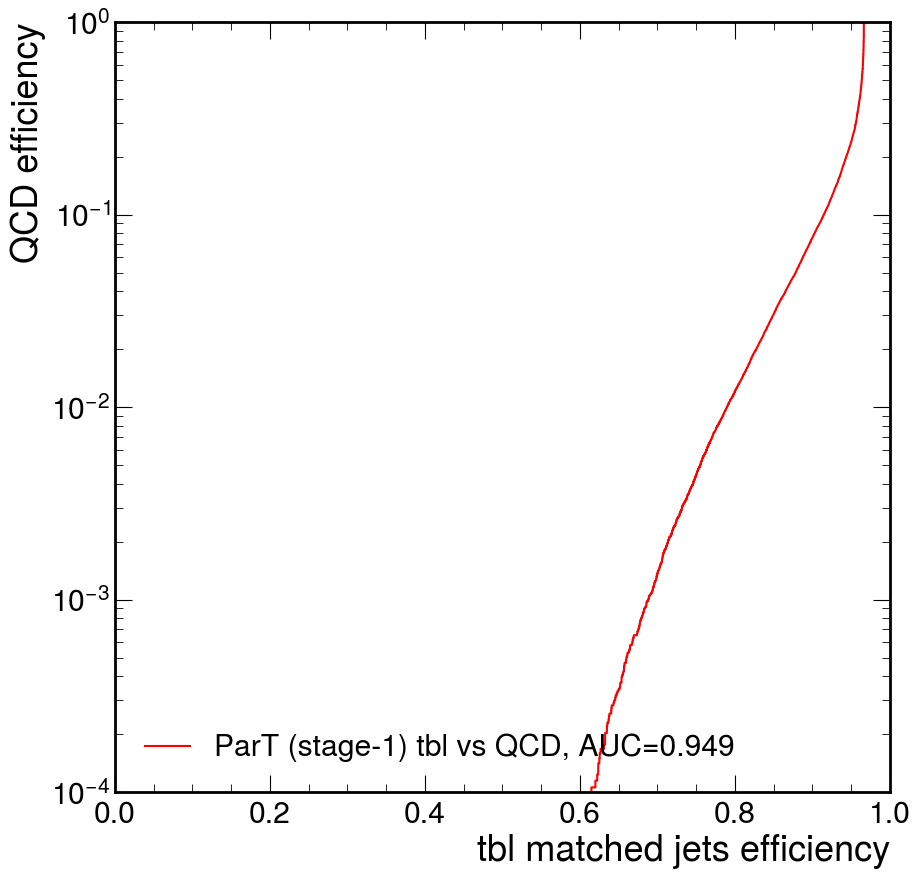

In [12]:
# make ROC curve by fj2_ParTV1_discr_blvsQCD

f, ax = plt.subplots(figsize=(10,10))

y_score =  np.nan_to_num(ak.to_numpy(df.fj1_ParTV1_discr_blvsQCD))
y_true = ak.to_numpy(df.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'ParT (stage-1) tbl vs QCD, AUC={m.auc(fpr, tpr):.3f}')

# scattering plots with anotations to show effs
# for k, v in effs.items():
#     ax.scatter(*v, color='green')
# for k, v in effs1.items():
#     ax.scatter(*v, color='darkgreen')
#     # ax.annotate(k, v, textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

ax.set_xlabel('tbl matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "lower left")


plt.savefig(f"{plot_dir}/ROC_2.pdf")
plt.show()

### Add e-top tagger and compare the performance

In [5]:
df0_ele = uproot.lazy('/data/bond/zhaoyz/DeepDive/top_tagging_ntuples/electon_top_tagger/background_b_enriched_qcd_sample/EE_Summer20UL18_b_QCD_MG_1500to2000_fortraining_output.root')
df0_ele['event_type'] = 0
df1_ele = uproot.lazy('/data/bond/zhaoyz/DeepDive/top_tagging_ntuples/electon_top_tagger/signal_ttbar_sample/EE_Summer20UL18_TTBar_DiLeptonic_fortraining_output.root')
df1_ele['event_type'] = 1
df_ele = ak.concatenate([df0_ele, df1_ele])

/tmp/ipykernel_1149257/3244817862.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_ele.event_type).astype(np.int)


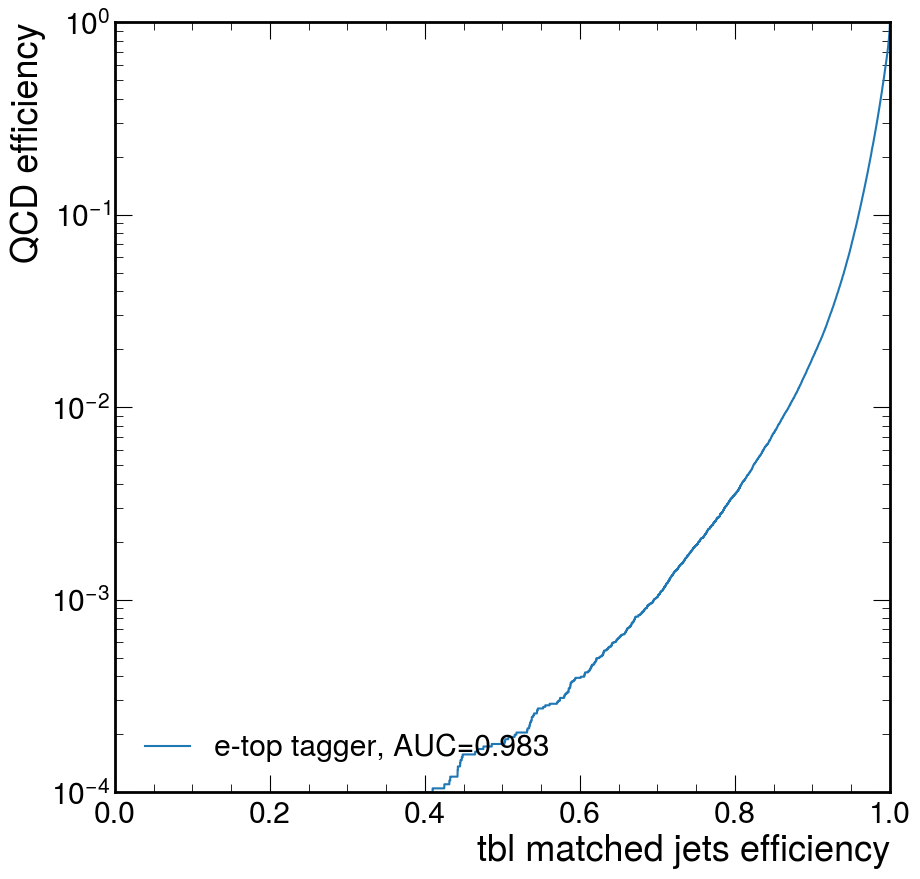

In [9]:
# make ROC curve by e-top tagger

f, ax = plt.subplots(figsize=(10,10))

y_score =  np.nan_to_num(ak.to_numpy(df_ele.selpfjetAK8score))
y_true = ak.to_numpy(df_ele.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'e-top tagger, AUC={m.auc(fpr, tpr):.3f}')

ax.set_xlabel('tbl matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "lower left")


plt.savefig(f"{plot_dir}/ROC_ele.pdf")
plt.show()

### Add mu-top tagger and compare the performance

In [13]:
df0_mu = uproot.lazy('/data/bond/zhaoyz/DeepDive/top_tagging_ntuples/muon_top_tagger/background_b_enriched_qcd_sample/EE_Summer20UL18_b_QCD_MG_1500to2000_fortraining_output.root')
df0_mu['event_type'] = 0
df1_mu = uproot.lazy('/data/bond/zhaoyz/DeepDive/top_tagging_ntuples/muon_top_tagger/signal_ttbar_sample/EE_Summer20UL18_TTBar_DiLeptonic_fortraining_output.root')
df1_mu['event_type'] = 1
df_mu = ak.concatenate([df0_mu, df1_mu])

/tmp/ipykernel_1149257/210780926.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_mu.event_type).astype(np.int)


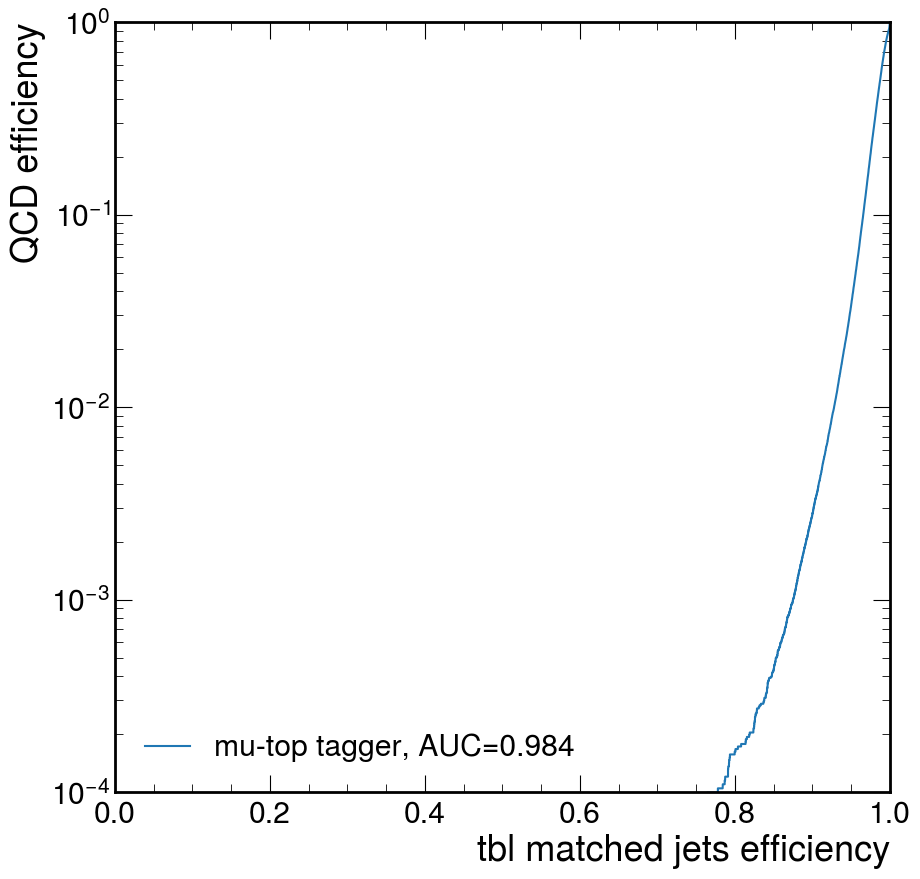

In [14]:
# make ROC curve by mu-top tagger

f, ax = plt.subplots(figsize=(10,10))

y_score =  np.nan_to_num(ak.to_numpy(df_mu.selpfjetAK8score))
y_true = ak.to_numpy(df_mu.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'mu-top tagger, AUC={m.auc(fpr, tpr):.3f}')

ax.set_xlabel('tbl matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "lower left")


plt.savefig(f"{plot_dir}/ROC_muon.pdf")
plt.show()

### efficiency as a function of pT

In [34]:
WPs_dict = {
    "0.1% mis-tag rate" : 0.887,
    "1% mis-tag rate" : 0.27,
    "5% mis-tag rate" :0.0408,
    "10% mis-tag rate" :0.0125,
    } #inclusive 1%, 5%, 10% mis-tag rate

def plot_effi_pt(df, WP_percent = 0.27, WP_str = "1% mis-tag rate", suffix = "1"):
    f, ax = plt.subplots(figsize=(10,10))
    hep.cms.label(data=False, year="2017", ax=ax, fontname='sans-serif')
    plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','darkviolet'])
    nbin, xmin, xmax = 50, 0, 1000
    # bins = np.array([0, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
    
    bins_0_400 = np.arange(0, 400 + 20, 20)  # 0-400 GeV, 20 GeV/bin
    bins_400_1000 = np.arange(400, 1000 + 50, 50)  # 400-1000 GeV, 50 GeV/bin

    bins = np.concatenate([bins_0_400, bins_400_1000[1:]])
    
    hist_num = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    hist_num.fill(df.fj1_pt[(df.fj1_ParTV1_discr_blvsQCD > WP_percent) & (df.event_type == 1)])
    content_num, yerr_num = hist_num.view().value, np.sqrt(hist_num.view().variance)
        
    hist_denom = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    hist_denom.fill(df.fj1_pt[(df.event_type == 1)])
    content_denom, yerr_denom = hist_denom.view().value, np.sqrt(hist_denom.view().variance)
    
    eff = content_num/content_denom
    err_eff = (content_num/content_denom)*np.sqrt(np.power(yerr_num/content_num,2) + np.power(yerr_denom/content_denom,2))
    upper_bounds = np.minimum(1 - eff, err_eff)
    
    hep.histplot(eff, bins=hist_denom.axes[0].edges, yerr=[err_eff, upper_bounds],label = f"tbl matched jets, at {WP_str}")
    
    ax.legend(loc="upper left",frameon=False,fontsize=21)
    ax.set_xlabel('tbl matched jets pT', ha='right', x=1.0); 
    ax.set_ylabel('efficiency', ha='right', y=1.0);
    plt.ylim(0, 1.2)
    # ax.set_yscale("log")
    plt.savefig(f"{plot_dir}/efficiency_{suffix}.pdf")
    plt.show()
    

/tmp/ipykernel_3041792/16515134.py:28: RuntimeWarning: invalid value encountered in true_divide
  eff = content_num/content_denom
/tmp/ipykernel_3041792/16515134.py:29: RuntimeWarning: invalid value encountered in true_divide
  err_eff = (content_num/content_denom)*np.sqrt(np.power(yerr_num/content_num,2) + np.power(yerr_denom/content_denom,2))


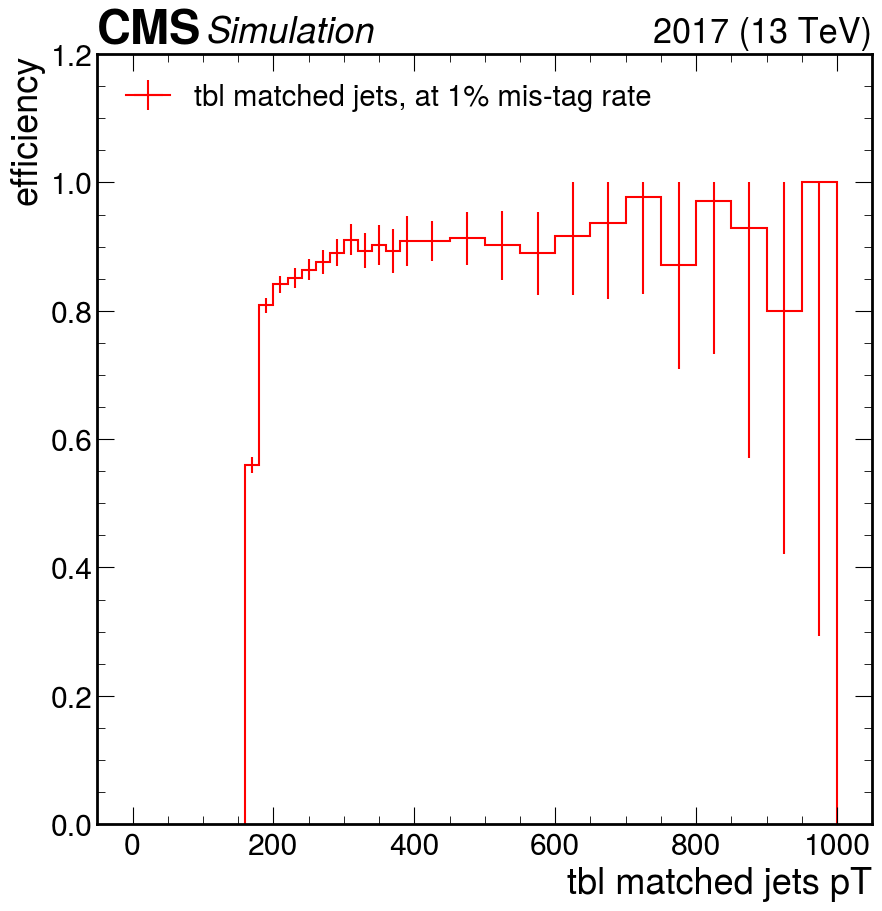

In [35]:
plot_effi_pt(df,WP_percent = WPs_dict["1% mis-tag rate"], WP_str = "1% mis-tag rate", suffix = "1")

/tmp/ipykernel_3041792/16515134.py:28: RuntimeWarning: invalid value encountered in true_divide
  eff = content_num/content_denom
/tmp/ipykernel_3041792/16515134.py:29: RuntimeWarning: invalid value encountered in true_divide
  err_eff = (content_num/content_denom)*np.sqrt(np.power(yerr_num/content_num,2) + np.power(yerr_denom/content_denom,2))


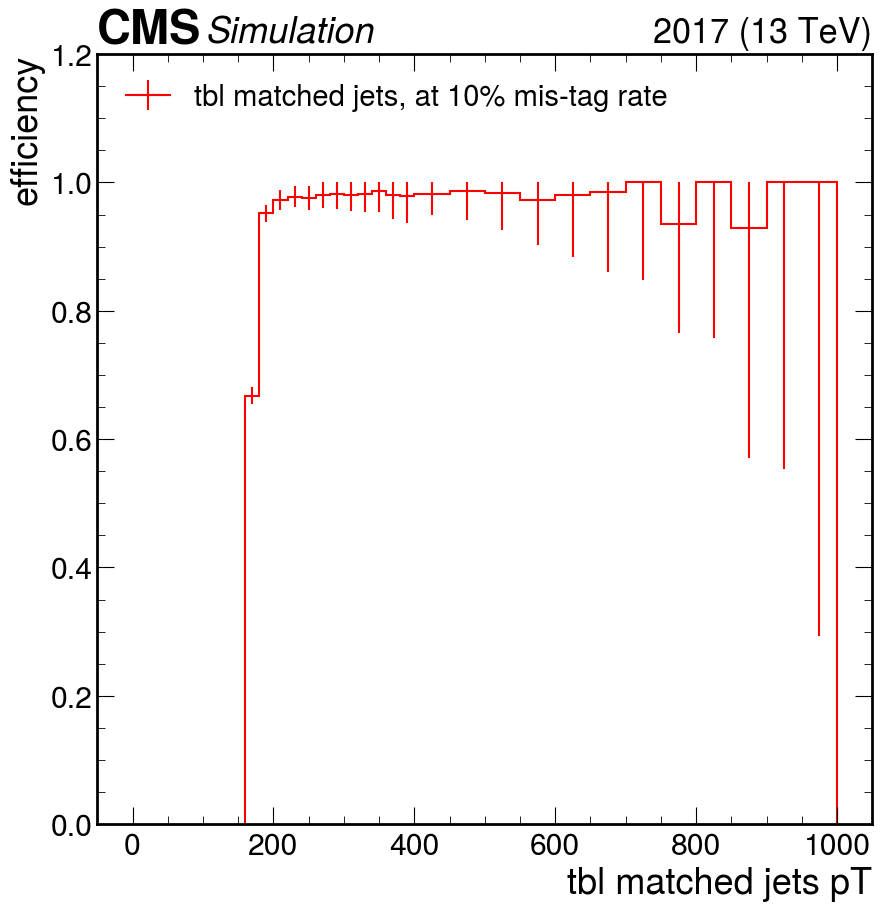

In [36]:
plot_effi_pt(df,WP_percent = WPs_dict["10% mis-tag rate"], WP_str = "10% mis-tag rate", suffix = "10")

/tmp/ipykernel_3041792/16515134.py:28: RuntimeWarning: invalid value encountered in true_divide
  eff = content_num/content_denom
/tmp/ipykernel_3041792/16515134.py:29: RuntimeWarning: invalid value encountered in true_divide
  err_eff = (content_num/content_denom)*np.sqrt(np.power(yerr_num/content_num,2) + np.power(yerr_denom/content_denom,2))


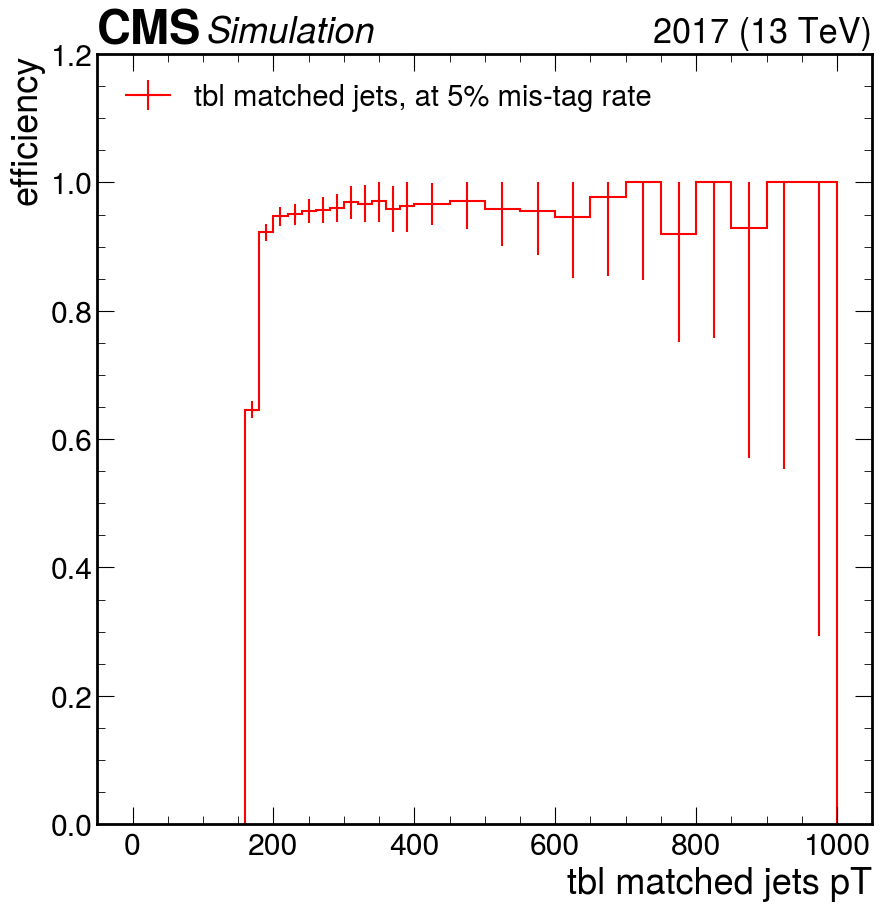

In [37]:
plot_effi_pt(df,WP_percent = WPs_dict["5% mis-tag rate"], WP_str = "5% mis-tag rate", suffix = "5")

/tmp/ipykernel_3041792/16515134.py:28: RuntimeWarning: invalid value encountered in true_divide
  eff = content_num/content_denom
/tmp/ipykernel_3041792/16515134.py:29: RuntimeWarning: invalid value encountered in true_divide
  err_eff = (content_num/content_denom)*np.sqrt(np.power(yerr_num/content_num,2) + np.power(yerr_denom/content_denom,2))


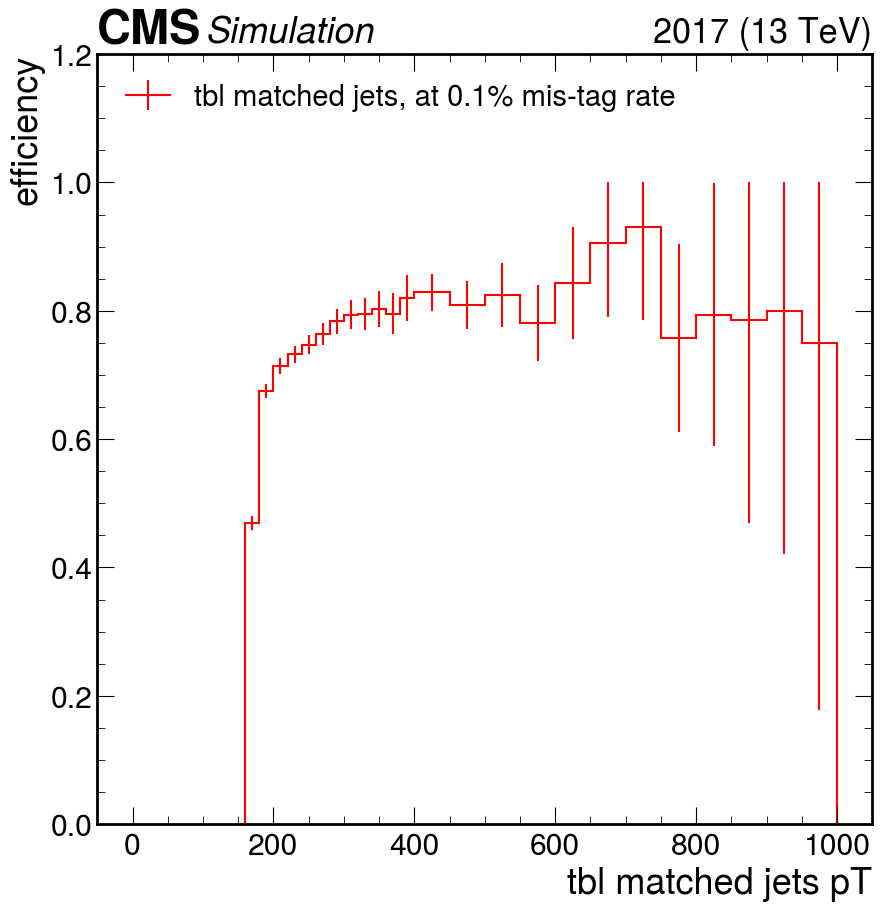

In [38]:
plot_effi_pt(df,WP_percent = WPs_dict["0.1% mis-tag rate"], WP_str = "0.1% mis-tag rate", suffix = "0p1")